### Import Libraries

In [1]:

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

### Load Data

In [2]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [3]:
dataset_path = r"C:\Users\darsh\OneDrive\Desktop\Car Damage Detection\training\dataset"

dataset = datasets.ImageFolder(root= dataset_path,transform=image_transforms)
len(dataset)

2300

In [4]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [21]:
class_names = dataset.classes
class_names 

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [5]:
num_classes = len(dataset.classes)
num_classes

6

In [6]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_size,val_size

(1725, 575)

In [7]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [9]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [10]:
images[1].shape

torch.Size([3, 224, 224])

In [11]:
labels[1]

tensor(1)

In [12]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


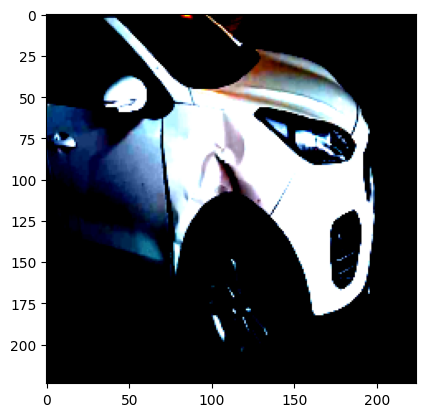

In [13]:
plt.imshow(images[1].permute(1,2,0))

### Model 1: CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), # in(3,224,224)  out(16,224,224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # out(16,112,112)
            
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), # in(16,112,112)  out(32,112,112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # out(32,56,56)

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # in(32,112,112)  out(64,112,112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # out(64,28,28)

            nn.Flatten(),

            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
            
        )
    def forward(self,x):
        x = self.network(x)
        return x
    

In [62]:
# Model Initialization, Optimizer & Loss Function

model = CarClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)


In [16]:
def train_model(model,criterion,optimizer,epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num,(images,labels) in enumerate(train_loader):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)
            loss = criterion(outputs,labels)

            # backward pass & optimization
            loss.backward()
            optimizer.step() # update weights

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num +1},Epoch :{epoch+1}, Loss:{loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch +1}/{epochs}], Avg Loss:{epoch_loss:.4f}")

        # Validation
        model.eval()
        correct=0
        total=0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images,labels  in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels)
                all_predictions.extend(predicted)

            print(f"*** Validation Accuracy:{100 * correct /total:.2f}%***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions
            

In [ ]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10,Epoch :1, Loss:0.34
Batch: 20,Epoch :1, Loss:0.17
Batch: 30,Epoch :1, Loss:0.03
Batch: 40,Epoch :1, Loss:0.06
Batch: 50,Epoch :1, Loss:0.18
Epoch [1/10], Avg Loss:0.1104
*** Validation Accuracy:82.61%***
Batch: 10,Epoch :2, Loss:0.27
Batch: 20,Epoch :2, Loss:0.05
Batch: 30,Epoch :2, Loss:2.42
Batch: 40,Epoch :2, Loss:0.09
Batch: 50,Epoch :2, Loss:0.27
Epoch [2/10], Avg Loss:0.2023


### Model 2: CNN with Regularization

In [24]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(  
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)  
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            
            nn.Flatten(),
            
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [25]:
# Model Initialization, Optimizer & Loss Function

model = CarClassifierCNNWithRegularization(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay = 1e-4) # weight_decay = 0.0001



In [26]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10,Epoch :1, Loss:20.95
Batch: 20,Epoch :1, Loss:6.77
Batch: 30,Epoch :1, Loss:2.60
Batch: 40,Epoch :1, Loss:1.63
Batch: 50,Epoch :1, Loss:1.53
Epoch [1/10], Avg Loss:8.1970
*** Validation Accuracy:38.43%***
Batch: 10,Epoch :2, Loss:1.28
Batch: 20,Epoch :2, Loss:1.70
Batch: 30,Epoch :2, Loss:1.67
Batch: 40,Epoch :2, Loss:1.51
Batch: 50,Epoch :2, Loss:1.47
Epoch [2/10], Avg Loss:1.4687
*** Validation Accuracy:46.26%***
Batch: 10,Epoch :3, Loss:1.29
Batch: 20,Epoch :3, Loss:1.58
Batch: 30,Epoch :3, Loss:1.55
Batch: 40,Epoch :3, Loss:1.26
Batch: 50,Epoch :3, Loss:1.09
Epoch [3/10], Avg Loss:1.3860
*** Validation Accuracy:47.83%***
Batch: 10,Epoch :4, Loss:1.12
Batch: 20,Epoch :4, Loss:1.27
Batch: 30,Epoch :4, Loss:1.50
Batch: 40,Epoch :4, Loss:1.96
Batch: 50,Epoch :4, Loss:1.52
Epoch [4/10], Avg Loss:1.3287
*** Validation Accuracy:44.87%***
Batch: 10,Epoch :5, Loss:1.25
Batch: 20,Epoch :5, Loss:1.29
Batch: 30,Epoch :5, Loss:1.36
Batch: 40,Epoch :5, Loss:1.30
Batch: 50,Epoch :5, Los

### Model 3: Transfer Learning with EfficientNet

In [27]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters(): # Freeze the upper layer
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        x = self.model(x)
        return x
        

In [28]:
# Model Initialization, Optimizer & Loss Function

model = CarClassifierEfficientNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001) 

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\darsh/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:02<00:00, 8.12MB/s]


Batch: 10,Epoch :1, Loss:1.70
Batch: 20,Epoch :1, Loss:1.58
Batch: 30,Epoch :1, Loss:1.47
Batch: 40,Epoch :1, Loss:1.32
Batch: 50,Epoch :1, Loss:1.35
Epoch [1/10], Avg Loss:1.4770
*** Validation Accuracy:58.78%***
Batch: 10,Epoch :2, Loss:1.19
Batch: 20,Epoch :2, Loss:1.22
Batch: 30,Epoch :2, Loss:1.12
Batch: 40,Epoch :2, Loss:1.04
Batch: 50,Epoch :2, Loss:1.14
Epoch [2/10], Avg Loss:1.1498
*** Validation Accuracy:63.30%***
Batch: 10,Epoch :3, Loss:0.99
Batch: 20,Epoch :3, Loss:0.92
Batch: 30,Epoch :3, Loss:1.17
Batch: 40,Epoch :3, Loss:0.85
Batch: 50,Epoch :3, Loss:1.05
Epoch [3/10], Avg Loss:1.0252
*** Validation Accuracy:66.96%***
Batch: 10,Epoch :4, Loss:1.27
Batch: 20,Epoch :4, Loss:0.89
Batch: 30,Epoch :4, Loss:0.91
Batch: 40,Epoch :4, Loss:1.03
Batch: 50,Epoch :4, Loss:0.85
Epoch [4/10], Avg Loss:0.9612
*** Validation Accuracy:65.57%***
Batch: 10,Epoch :5, Loss:1.06
Batch: 20,Epoch :5, Loss:1.02
Batch: 30,Epoch :5, Loss:0.93
Batch: 40,Epoch :5, Loss:0.79
Batch: 50,Epoch :5, Loss

### Model 4: Trasfer Learning with ResNet 

In [14]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer 
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features,num_classes)
        )
    def forward(self,x):
        x = self.model(x)
        return x
        

In [17]:
model = CarClassifierResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.001)

labels, predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10,Epoch :1, Loss:0.99
Batch: 20,Epoch :1, Loss:0.81
Batch: 30,Epoch :1, Loss:0.96
Batch: 40,Epoch :1, Loss:0.94
Batch: 50,Epoch :1, Loss:0.90
Epoch [1/10], Avg Loss:0.9148
*** Validation Accuracy:70.09%***
Batch: 10,Epoch :2, Loss:0.50
Batch: 20,Epoch :2, Loss:0.44
Batch: 30,Epoch :2, Loss:0.41
Batch: 40,Epoch :2, Loss:0.43
Batch: 50,Epoch :2, Loss:0.54
Epoch [2/10], Avg Loss:0.5025
*** Validation Accuracy:81.04%***
Batch: 10,Epoch :3, Loss:0.58
Batch: 20,Epoch :3, Loss:0.31
Batch: 30,Epoch :3, Loss:0.25
Batch: 40,Epoch :3, Loss:0.29
Batch: 50,Epoch :3, Loss:0.62
Epoch [3/10], Avg Loss:0.3687
*** Validation Accuracy:78.09%***
Batch: 10,Epoch :4, Loss:0.49
Batch: 20,Epoch :4, Loss:0.41
Batch: 30,Epoch :4, Loss:0.16
Batch: 40,Epoch :4, Loss:0.26
Batch: 50,Epoch :4, Loss:0.12
Epoch [4/10], Avg Loss:0.2847
*** Validation Accuracy:79.13%***
Batch: 10,Epoch :5, Loss:0.15
Batch: 20,Epoch :5, Loss:0.15
Batch: 30,Epoch :5, Loss:0.34
Batch: 40,Epoch :5, Loss:0.20
Batch: 50,Epoch :5, Loss

#### With HyperParameter Tuning, the best parameter for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

#### now let's train the model once again with these best parameters 

In [18]:
model = CarClassifierResNet(num_classes = num_classes,dropout_rate = 0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.005)

labels, predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10,Epoch :1, Loss:0.80
Batch: 20,Epoch :1, Loss:1.13
Batch: 30,Epoch :1, Loss:0.62
Batch: 40,Epoch :1, Loss:0.75
Batch: 50,Epoch :1, Loss:0.43
Epoch [1/10], Avg Loss:0.8869
*** Validation Accuracy:76.17%***
Batch: 10,Epoch :2, Loss:0.38
Batch: 20,Epoch :2, Loss:0.57
Batch: 30,Epoch :2, Loss:0.49
Batch: 40,Epoch :2, Loss:0.67
Batch: 50,Epoch :2, Loss:0.50
Epoch [2/10], Avg Loss:0.5230
*** Validation Accuracy:77.91%***
Batch: 10,Epoch :3, Loss:0.56
Batch: 20,Epoch :3, Loss:0.39
Batch: 30,Epoch :3, Loss:0.41
Batch: 40,Epoch :3, Loss:0.41
Batch: 50,Epoch :3, Loss:0.21
Epoch [3/10], Avg Loss:0.3649
*** Validation Accuracy:76.87%***
Batch: 10,Epoch :4, Loss:0.21
Batch: 20,Epoch :4, Loss:0.30
Batch: 30,Epoch :4, Loss:0.08
Batch: 40,Epoch :4, Loss:0.10
Batch: 50,Epoch :4, Loss:0.21
Epoch [4/10], Avg Loss:0.2720
*** Validation Accuracy:77.22%***
Batch: 10,Epoch :5, Loss:0.18
Batch: 20,Epoch :5, Loss:0.13
Batch: 30,Epoch :5, Loss:0.27
Batch: 40,Epoch :5, Loss:0.21
Batch: 50,Epoch :5, Loss

## Model Evaluation using Confusion Matrix and classification Report

In [19]:
from sklearn.metrics import classification_report

report = classification_report(labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       114
           1       0.74      0.81      0.77        95
           2       0.87      0.95      0.91       132
           3       0.90      0.58      0.71        79
           4       0.63      0.63      0.63        79
           5       0.67      0.91      0.77        76

    accuracy                           0.79       575
   macro avg       0.79      0.77      0.77       575
weighted avg       0.80      0.79      0.79       575



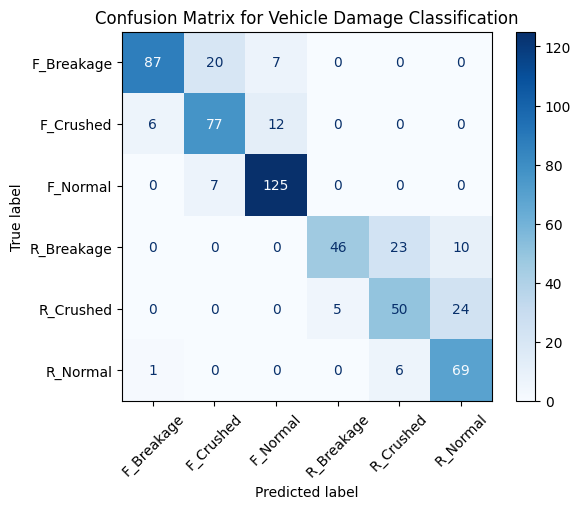

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels,predictions,labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [23]:
torch.save(model.state_dict(), 'saved_model.pth')